In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# FLUX.1 [dev] Pipeline Optimized with <span style='color: #76B900'>TensorRT-RTX</span>

In [2]:
import sys
import os
from pathlib import Path
import gc
import torch

# Add ../../demo/ to current path
if "__session__" in locals():
    sys.path.append(str(Path(os.path.realpath(__session__)).parent.parent)) # noqa: F821

from ipywidgets import Output
from pipelines.flux_pipeline import FluxPipeline
from utils.notebook_utils import printmd, display_image_from_path, markdown_bold_green_format

In [3]:
DEMO_CACHE_DIR = "./demo_cache/"  # Where the demo ONNX, engine, and metadata will be stored
DEMO_CACHE_MODE = "full"  # "full" or "lean" depending on whether you would like files to be cleaned up after every section of the demo
HF_TOKEN = "YOUR_HF_TOKEN"  # HuggingFace Token with access to the FLUX.1[dev] model repo
LOG_LEVEL = "INFO"
DEVICE = "cuda"
assert HF_TOKEN != "YOUR_HF_TOKEN", "Please set your HuggingFace token in the HF_TOKEN variable" 

# 1. Quickstart

### Overview
We provide a demonstration of running FLUX.1 [dev] in a variety of precisions. It showcases the steps involved in accelerating inference in real-world model pipelines using TensorRT-RTX.

> **Note:** This end-to-end notebook was verified on an NVIDIA Blackwell GPU. See _"Transformer Precision Options"_ of `demo/README.md` for more compatibility details.

#### Features Highlighted

1. **JIT Compilation**: Specializes the TensorRT-RTX engine to the GPU on which you are running inference
2. **Runtime Caching**: Faster JIT times through caching kernel compilations
3. **Dynamic Shape Specialization**: Substitution of performant, shape-specialized kernels in the background based on input shapes observed at runtime
4. **Quantization**: Faster inference and smaller engines using FP8 and NVFP4 data types
    1. _For convenience, our demonstration uses pre-quantized models downloaded from HuggingFace. We recommend using NVIDIA TensorRT Model Optimizer for quantizing models for deployment with TensorRT-RTX._
5. **Low-VRAM Mode**: Pipeline setting where components are offloaded to CPU when not in use, to conserve GPU memory

> **Note:**  We recommend running using a GPU with 32GB of memory; the NVFP4 quantized model run in **Low-VRAM Mode** can run on GPUs with 16GB of memory.

#### Configure Parameters
- `height` = Height of the output image (generally keep to multiples of 16)
- `width` = Width of the output image (generally keep to multiples of 16)
- `batch_size`: Number of images to generate per prompt
- `seed`: Parameter for random initializations (try different values to vary your outputs)
- `num_inference_steps`: How many iterations of denoising to run on the image (generally, higher = better quality)
- `guidance_scale`: Proximity of the image to the input prompt, in meaning (generally, higher = more fidelity to the input prompt)
- `prompt`: The text describing the desired content of the image

#### Initialize the Pipeline
```python
# Initialize a pipeline instance
pipeline = FluxPipeline( ... )
# Load engines
pipeline.load_engines( ... )
# Load resources (input/output buffers, workspace)
pipeline.load_resources( ... )
# Run Inference
pipeline.infer( ... )
```

#### Notes and Troubleshooting
- Some of the cells in the notebook may take a long time to execute (5-10 minutes).
  - These are copying files and building engines for multiple large component models in the FLUX pipeline and thus require a large amount of time to generate.
- Some of the model precisions in this notebook may not work on all GPUs.
  - FP8 is expected to work on Ada (Compute Capability 89) and later GPUs
  - FP4 is expected to work on Blackwell (Compute Capability 120) and later GPUs
- Some of the sections of this notebook may not work on all GPUs, due to memory constraints.
  - If you observe Out-Of-Memory issues, try the last sections, **Further Quantization** and **Low-VRAM Mode** first.
- If you observe high disk space usage in the cache, consider using `DEMO_CACHE_MODE = "lean"`, which will delete unused models and engines.
  - With lean cache mode, we observe ~55-60 GB of disk space usage for FP8 models + engines and ~30-35 GB of disk space usage for FP4 models + engines
- If you switch cache modes and see runtime issues or observe unexpected errors with your built engines, try deleting the cache directory and re-running.

## Model Configuration

In [4]:
# =====================================================================================================
# CONFIGURATION - Modify these parameters as desired for the subsequent blocks in this section
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 512
width = 512
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 1294
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop"

## Pipeline Initialization

In [5]:
printmd(f"Initializing Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision...")
pipeline = FluxPipeline(
    cache_dir=DEMO_CACHE_DIR,
    device=DEVICE,
    verbose=False,
    cache_mode=DEMO_CACHE_MODE,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    hf_token=HF_TOKEN,
    log_level=LOG_LEVEL,
    enable_runtime_cache=True,
)

printmd("**Building and Loading engines**...")
initial_jit_times = pipeline.load_engines(
    transformer_precision="fp8",
    opt_batch_size=batch_size,
    opt_height=height,
    opt_width=width,
    shape_mode="static",
)

printmd("**Loading resources**...")
pipeline.load_resources(
    batch_size=batch_size,
    height=height,
    width=width,
)

for model, initial_jit_time in initial_jit_times.items():
    printmd(markdown_bold_green_format("JIT Compilation") +
            f" + Execution Context Creation Time for **{model}**: {round(initial_jit_time, 2)} seconds")

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision...

[2025-06-11 22:04:30] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: /tmp/demo_cache, Mode: full
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


**Building and Loading engines**...

[2025-06-11 22:04:33] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_transformer/fp8/flux_transformer_static.engine


[2025-06-11 22:04:40] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-06-11 22:04:40] [rtx_demo.utils.engine] [INFO] Using existing runtime cache


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:04:40] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-06-11 22:04:48] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-06-11 22:04:49] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.1 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.12 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 8.0 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 0.38 seconds

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1294


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:04:53] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**Generated Image(s) in 3.99s**


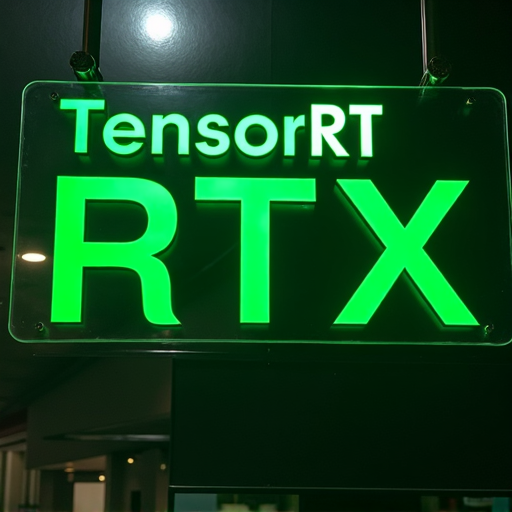

In [6]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup()
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# 2. Runtime Caching
<span style='color: #76B900'>TensorRT-RTX</span> introduces _Runtime Caching_, a feature which enables accelerated JIT compilation using a serializable cache. Here, we feature the JIT-time improvement observed when utilizing the runtime cache.

In [7]:
printmd("**Reloading engines with Runtime Cache**...")
printmd(f"Initializing Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision...")
pipeline = FluxPipeline(
    cache_dir=DEMO_CACHE_DIR,
    device=DEVICE,
    verbose=False,
    cache_mode=DEMO_CACHE_MODE,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    hf_token=HF_TOKEN,
    low_vram=False,
    log_level=LOG_LEVEL,
    enable_runtime_cache=True,
)

printmd("**Building and Loading engines**...")
rt_cache_jit_times = pipeline.load_engines(
    transformer_precision="fp8",
    opt_batch_size=batch_size,
    opt_height=height,
    opt_width=width,
    shape_mode="static",
)

printmd("**Loading resources**...")
pipeline.load_resources(
    batch_size=batch_size,
    height=height,
    width=width,
)

rt_cache_jit_time_sum, initial_cache_jit_time_sum = 0, 0
for model in rt_cache_jit_times:
    assert model in initial_jit_times
    rt_cache_jit_time_sum += rt_cache_jit_times[model]
    initial_cache_jit_time_sum += initial_jit_times[model]

printmd(markdown_bold_green_format("Runtime Cache JIT Compilation") +
        f" + Execution Context Creation Time for **FLUX.1 [dev] Pipeline**: {round(rt_cache_jit_time_sum, 2)} seconds, "
        f"a **{round(initial_cache_jit_time_sum / rt_cache_jit_time_sum, 2)}x** Improvement")

**Reloading engines with Runtime Cache**...

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision...

[2025-06-11 22:04:55] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: /tmp/demo_cache, Mode: full


**Building and Loading engines**...

[2025-06-11 22:04:56] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_transformer/fp8/flux_transformer_static.engine


[2025-06-11 22:05:03] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-06-11 22:05:03] [rtx_demo.utils.engine] [INFO] Loading runtime cache from /tmp/demo_cache/runtime.cache
[2025-06-11 22:05:03] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:05:04] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-06-11 22:05:04] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-06-11 22:05:04] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-06-11 22:05:04] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>Runtime Cache JIT Compilation</span> + Execution Context Creation Time for **FLUX.1 [dev] Pipeline**: 0.29 seconds, a **29.34x** Improvement

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Runtime Caching


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1294


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:05:08] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**Generated Image(s) in 3.89s**


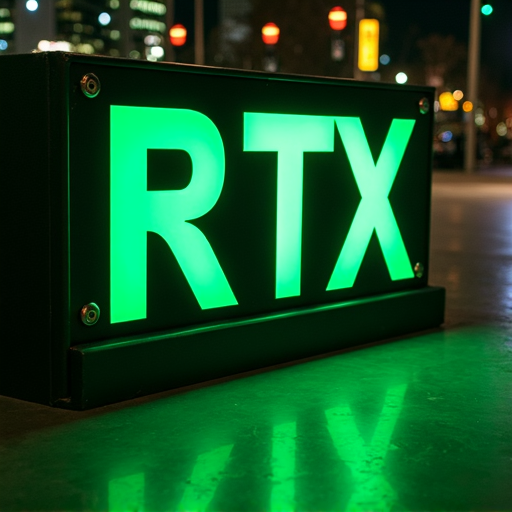

In [8]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Runtime Caching\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed + 1,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup()
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# 3. Dynamic Shape Specialization
<span style='color: #76B900'>TensorRT-RTX</span> also introduces new dynamic shapes features. At runtime, when the execution context is created, the JIT optimizations generate fallback kernels that can run inference on the entire range of input shapes. Then, as new shapes are encountered during inference, shape-specialized kernels are generated on the fly. These specialized kernels are compiled in a background thread while ‌initial inference requests are serviced using fallback kernels, then substituted in when ready for an efficient boost in performance.

In [9]:
# =====================================================================================================
# CONFIGURATION
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 512
width = 512
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 1001
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A cat meanders down a dimly lit alleyway in a large city."

In [10]:
printmd(f"Initializing Dynamic-Shapes Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision...")

pipeline = FluxPipeline(
    cache_dir=DEMO_CACHE_DIR,
    device=DEVICE,
    verbose=False,
    cache_mode=DEMO_CACHE_MODE,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    hf_token=HF_TOKEN,
    log_level=LOG_LEVEL,
)

printmd("**Building and Loading engines**...")
jit_times = pipeline.load_engines(
    transformer_precision="fp8",
    opt_batch_size=batch_size,
    opt_height=height,
    opt_width=width,
    shape_mode="dynamic",
)

printmd("**Loading resources**...")
pipeline.load_resources(
    batch_size=batch_size,
    height=height,
    width=width,
)

for model, jit_time in jit_times.items():
    printmd(markdown_bold_green_format("JIT Compilation") +
            f" + Execution Context Creation Time for **{model}**: {round(jit_time, 2)} seconds")

Initializing Dynamic-Shapes Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision...

[2025-06-11 22:05:10] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: /tmp/demo_cache, Mode: full


**Building and Loading engines**...

[2025-06-11 22:05:11] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Setting VAE Decoder to static shape to reduce VRAM usage
[2025-06-11 22:05:11] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'dynamic', 't5_text_encoder': 'dynamic', 'transformer': 'dynamic', 'vae_decoder': 'static'}


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_dynamic.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_dynamic.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_transformer/fp8/flux_transformer_dynamic.engine


[2025-06-11 22:05:19] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:05:20] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.05 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.07 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 0.45 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 0.35 seconds

**Prompt**: A cat meanders down a dimly lit alleyway in a large city.


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1001


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:05:24] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: 512 x 512</span>**

Transformer Iteration 1: 787.04ms (Fallback kernel)

Transformer Iteration 2: 71.63ms (Specialized kernel)

Transformer Iteration 3: 72.2ms (Specialized kernel)

Fallback-to-Specialized Kernel Improvement: **10.9x**

**Generated Image(s) in 4.59s**


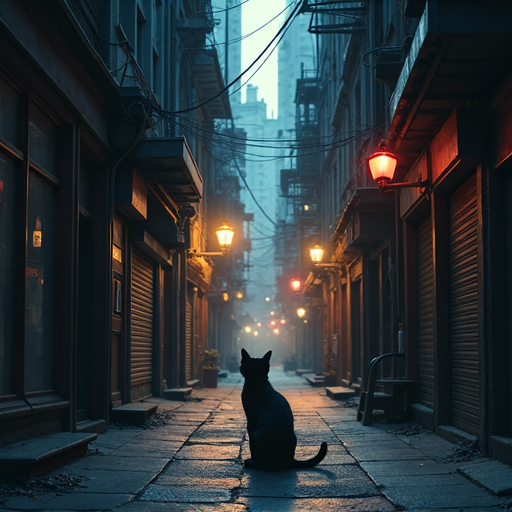

In [11]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: {width} x {height}</span>**", newlines=2)
printmd(f"Transformer Iteration 1: {round(timing_dict['transformer_runtimes_ms'][0], 2)}ms (Fallback kernel)")
printmd(f"Transformer Iteration 2: {round(timing_dict['transformer_runtimes_ms'][1], 2)}ms (Specialized kernel)")
printmd(f"Transformer Iteration 3: {round(timing_dict['transformer_runtimes_ms'][2], 2)}ms (Specialized kernel)")
printmd("Fallback-to-Specialized Kernel Improvement: "
        f"**{round(timing_dict['transformer_runtimes_ms'][0]/timing_dict['transformer_runtimes_ms'][2], 2)}x**")

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**", newlines=2)
for image_path in image_paths:
    display_image_from_path(image_path)

## Additional Unseen Shapes

In [12]:
# =====================================================================================================
# CONFIGURATION
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 576
width = 576
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 89
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A cat meanders down a dimly lit alleyway in a large city."

**Prompt**: A cat meanders down a dimly lit alleyway in a large city.


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Dynamic Shapes


[2025-06-11 22:05:25] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engine vae_decoder needs refresh: Shape profile incompatible: cached engine expects {'latent': [1, 16, 64, 64]}, user requested {'latent': (1, 16, 72, 72)}
[2025-06-11 22:05:25] [rtx_demo.utils.engine] [INFO] Building TensorRT engine for /tmp/demo_cache/shared/onnx/flux_vae_decoder/bf16/flux_vae_decoder.onnx: /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[I] Starting image generation with dimensions: 576 x 576 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 89
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:05:31] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Detected a shape change, reallocating resources


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:05:36] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (576, 576, 3)


**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: 576 x 576</span>**

Transformer Iteration 1: 538.4ms (Fallback kernel)

Transformer Iteration 2: 88.7ms (Specialized kernel)

Transformer Iteration 3: 89.55ms (Specialized kernel)

Fallback-to-Specialized Kernel Improvement: **6.01x**

**Generated Image(s) in 5.07s**


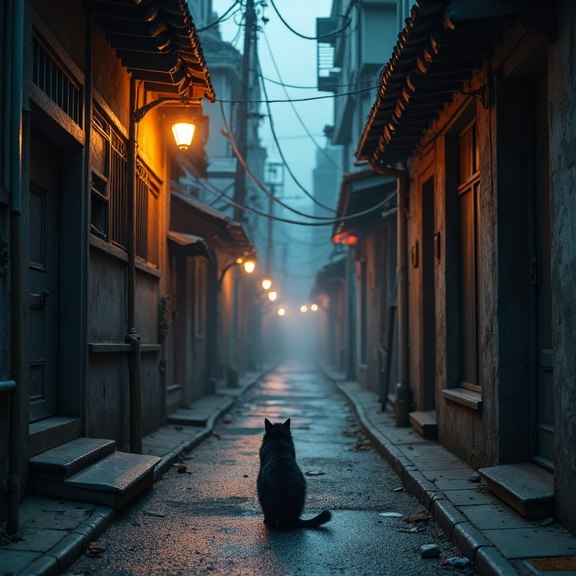

In [13]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: {width} x {height}</span>**", newlines=2)
printmd(f"Transformer Iteration 1: {round(timing_dict['transformer_runtimes_ms'][0], 2)}ms (Fallback kernel)")
printmd(f"Transformer Iteration 2: {round(timing_dict['transformer_runtimes_ms'][1], 2)}ms (Specialized kernel)")
printmd(f"Transformer Iteration 3: {round(timing_dict['transformer_runtimes_ms'][2], 2)}ms (Specialized kernel)")
printmd("Fallback-to-Specialized Kernel Improvement: "
        f"**{round(timing_dict['transformer_runtimes_ms'][0]/timing_dict['transformer_runtimes_ms'][2], 2)}x**")

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**", newlines=2)
for image_path in image_paths:
    display_image_from_path(image_path)

## Dynamic Shape Steady State
Now that the above shapes have been encountered at inference time, new runs of similar shapes within the execution context will have the specialized kernels available from the get-go:

In [14]:
# =====================================================================================================
# CONFIGURATION
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 512
width = 512
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 121
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A cat meanders down a dimly lit alleyway in a large city."

**Prompt**: A cat meanders down a dimly lit alleyway in a large city.


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Dynamic Shapes


[2025-06-11 22:05:38] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engine vae_decoder needs refresh: Shape profile incompatible: cached engine expects {'latent': [1, 16, 72, 72]}, user requested {'latent': (1, 16, 64, 64)}
[2025-06-11 22:05:38] [rtx_demo.utils.engine] [INFO] Building TensorRT engine for /tmp/demo_cache/shared/onnx/flux_vae_decoder/bf16/flux_vae_decoder.onnx: /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 121
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:05:43] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Detected a shape change, reallocating resources


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:05:47] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Steady State: 512 x 512</span>**

Transformer Iteration 1: 123.96ms (Specialized kernel, GPU Warmup)

Transformer Iteration 2: 71.69ms (Specialized kernel)

Transformer Iteration 3: 72.25ms (Specialized kernel)

**Generated Image(s) in 3.81s**


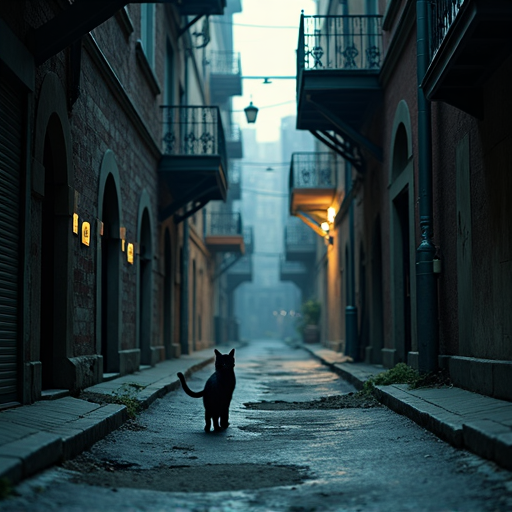

In [15]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Steady State: {width} x {height}</span>**", newlines=2)
printmd(f"Transformer Iteration 1: {round(timing_dict['transformer_runtimes_ms'][0], 2)}ms (Specialized kernel, GPU Warmup)")
printmd(f"Transformer Iteration 2: {round(timing_dict['transformer_runtimes_ms'][1], 2)}ms (Specialized kernel)")
printmd(f"Transformer Iteration 3: {round(timing_dict['transformer_runtimes_ms'][2], 2)}ms (Specialized kernel)")

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**", newlines=2)
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup()
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# 4. Further Quantization
We also showcase NVFP4 quantization which further decreases engine size and improves latency.

In [16]:
# =====================================================================================================
# CONFIGURATION
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 512
width = 512
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 1005
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A dramatic cityscape from a dazzling angle"

In [17]:
printmd(f"Initializing Dynamic-Shapes Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision...")

pipeline = FluxPipeline(
    cache_dir=DEMO_CACHE_DIR,
    device=DEVICE,
    verbose=False,
    cache_mode=DEMO_CACHE_MODE,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    hf_token=HF_TOKEN,
    log_level=LOG_LEVEL,
)

printmd("**Building and Loading engines**...")
jit_times = pipeline.load_engines(
    transformer_precision="fp4",
    opt_batch_size=batch_size,
    opt_height=height,
    opt_width=width,
    shape_mode="static",
)

printmd("**Loading resources**...")
pipeline.load_resources(
    batch_size=batch_size,
    height=height,
    width=width,
)

for model, jit_time in jit_times.items():
    printmd(markdown_bold_green_format("JIT Compilation") +
            f" + Execution Context Creation Time for **{model}**: {round(jit_time, 2)} seconds")

Initializing Dynamic-Shapes Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision...

[2025-06-11 22:05:48] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: /tmp/demo_cache, Mode: full


**Building and Loading engines**...

[2025-06-11 22:05:50] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_static.engine
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_transformer/fp4/flux_transformer_static.engine


[2025-06-11 22:05:55] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:06:05] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.1 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.11 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 8.93 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 0.36 seconds

**Prompt**: A dramatic cityscape from a dazzling angle


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1005


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:06:07] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**Generated Image(s) in 2.34s**


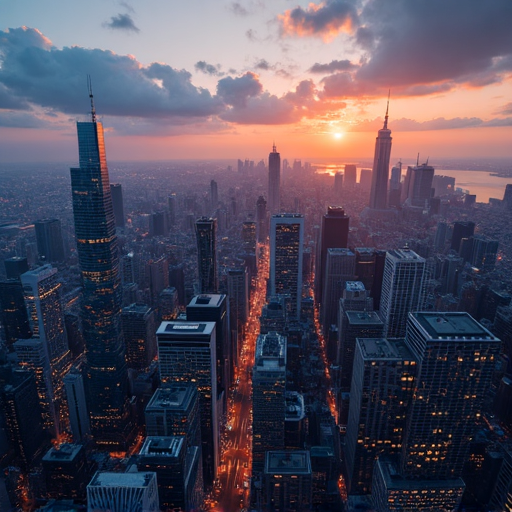

In [18]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup()
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# 5. Low VRAM Mode
In cases where GPU memory is limited, low-VRAM mode can help by offloading pipeline components to CPU. Note that the additional memory copies can add overhead to the end-to-end time.

In [19]:
# =====================================================================================================
# CONFIGURATION
# =====================================================================================================

# Image Shape + Quantity Parameters
height = 512
width = 512
batch_size = 1

# Image Quality, Randomness, Content Parameters
seed = 1025
num_inference_steps = 50
guidance_scale = 4.0
prompt = "A dramatic cityscape from a dazzling angle"

In [20]:
printmd(f"Initializing Dynamic-Shapes Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision...")

pipeline = FluxPipeline(
    cache_dir=DEMO_CACHE_DIR,
    device=DEVICE,
    verbose=False,
    cache_mode=DEMO_CACHE_MODE,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    hf_token=HF_TOKEN,
    log_level=LOG_LEVEL,
    low_vram=True,
)

printmd("**Building and Loading engines**...")
jit_times = pipeline.load_engines(
    transformer_precision="fp4",
    opt_batch_size=batch_size,
    opt_height=height,
    opt_width=width,
    shape_mode="static",
)

printmd("**Loading resources**...")
pipeline.load_resources(
    batch_size=batch_size,
    height=height,
    width=width,
)

for model, jit_time in jit_times.items():
    printmd(markdown_bold_green_format("JIT Compilation") +
            f" + Execution Context Creation Time for **{model}**: {round(jit_time, 2)} seconds")

Initializing Dynamic-Shapes Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision...

[2025-06-11 22:06:09] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: /tmp/demo_cache, Mode: full


**Building and Loading engines**...

[2025-06-11 22:06:10] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}
[2025-06-11 22:06:11] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-06-11 22:06:11] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

**Prompt**: A dramatic cityscape from a dazzling angle


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1025
[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_static.engine


[2025-06-11 22:06:14] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: /tmp/demo_cache/shared/engines/flux_t5_text_encoder/bf16/flux_t5_text_encoder_static.engine


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_static.engine


[2025-06-11 22:06:14] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: /tmp/demo_cache/shared/engines/flux_clip_text_encoder/bf16/flux_clip_text_encoder_static.engine


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_transformer/fp4/flux_transformer_static.engine


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-11 22:06:28] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: /tmp/demo_cache/shared/engines/flux_transformer/fp4/flux_transformer_static.engine


[I] Loading bytes from /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine


[2025-06-11 22:06:28] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: /tmp/demo_cache/shared/engines/flux_vae_decoder/bf16/flux_vae_decoder_static.engine
[2025-06-11 22:06:28] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: /tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**Generated Image(s) with Low-VRAM mode in 17.29s**


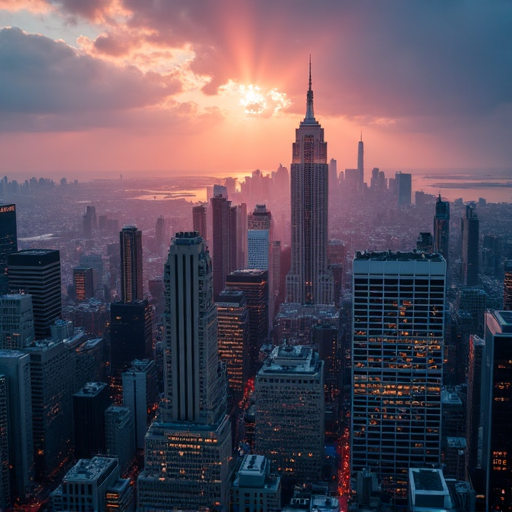

In [21]:
printmd(f"**Prompt**: {prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {width} x {height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {guidance_scale} and seed {seed}")

_, image_paths = pipeline.infer(prompt=prompt,
                                batch_size=batch_size,
                                height=height,
                                width=width,
                                seed=seed,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) with Low-VRAM mode in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup()
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()